## Movie Review Prediction with LSTM

In this notebook, we'll implement a recurrent neural network that performs movie review prediction. Here we'll use a dataset of movie reviews, accompanied by sentiment labels: positive or negative.


        
        
        What a wonderful movie!! 👍 (positive)

        I didn't like the main charecter 👎 (negetive)


In [71]:
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt

In [72]:
## Read the file

with open('data/reviews.txt') as f:
    reviews = f.read()
    
with open('data/labels.txt') as f:
    labels = f.read()

##### Visualize the data

In [73]:
print(reviews[:1000])
print(labels[:50])

bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   
story of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is turn

##### Data pre-processing

In [74]:
## Get rid of punctuations
reviews = reviews.lower()
all_text = ''.join([c for c in reviews if c not in punctuation])


In [75]:
reviews_split = all_text.split('\n')
reviews_split_len = np.zeros((len(reviews_split)))
for i,review in enumerate(reviews_split):
    reviews_split_len[i] = len(review)

In [76]:
## Average length of each review is 1332. But this may be too long to process

np.mean(reviews_split_len)
print(max(reviews_split_len))

13740.0


Text(0.5, 1.0, 'Review Length Distribution')

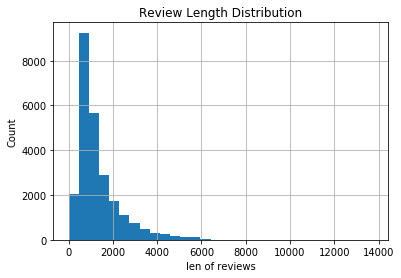

In [77]:
plt.hist(reviews_split_len,bins = 30)
plt.grid()
plt.xlabel('len of reviews')
plt.ylabel('Count')
plt.title('Review Length Distribution')

In [78]:
#len(least_used)
#len(words_count)

##There are 50k words which are used less than or equal to 5 times

In [79]:
##text_words = text

## The top 19 are the words are the words which are words which are used in most of the reviews
## irrespective of the 
words_count = Counter(all_text.split(' '))
most_common_19 = words_count.most_common(19)

top19words = []
for (word,count) in most_common_19:
    top19words.append(word)
    
top19words.remove('')
top19words

##**********

## Now lets check the least used words....

least_used = []
for (word,count) in words_count.items():
    if count <= 5:
        least_used.append(word)
print(len(least_used))

50154


In [80]:
import re
##result = all_text.split(' ')
#for item in top19words:
    #raw_item = re.escape(item)
    ##raw_item = r
#result = re.sub(r'the',  r'',    result)

In [81]:
##define the dictionary
def dic(all_text):
    reviews_split= all_text.split('\n')
    all_text = ' '.join(reviews_split)
    words = all_text.split()
    word_count = Counter(words)
    vocab = sorted(word_count, key = word_count.get, reverse = True)
    vocab_2_int = {word:ii for ii, word in enumerate(vocab,1)}
    int_2_vocab = { ii:word for word,ii in vocab_2_int.items()}
    tokens = str(set(words))
    return reviews_split,tokens, vocab_2_int,int_2_vocab

###
reviews_split,tokens, vocab_2_int,int_2_vocab = dic(all_text)

In [82]:
len(reviews_split)

25001

In [83]:
def review2int(reviews_split,vocab_2_int):
    reviews_int= []
    for review in reviews_split:
        reviews_int.append([vocab_2_int[word] for word in review.split() if vocab_2_int.get(word,-1) != -1])
    return reviews_int
    
### Test

reviews_int = review2int(reviews_split,vocab_2_int)
len(reviews_int)

25001

In [84]:
review_lens = Counter([len(x) for x in reviews_int])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 1
Maximum review length: 2514


In [85]:
## Convert target to numeric
def label2int(labels):
    labels = labels.split('\n')
    targets = []
    for label in labels:
        if label == 'positive':
            targets.append(1)
        else:
            targets.append(0)
        
    encoded_labels =np.array(targets)
    return encoded_labels

## test

encoded_labels = label2int(labels)
len(encoded_labels)

25001

In [86]:
## Remove NULL reviews

def remove_NULL_review(reviews_int,encoded_labels):
    reviews_int_upd = []
    encoded_labels_upd = []
    for i,review in enumerate(reviews_int):
        if len(review) != 0:
            reviews_int_upd.append(reviews_int[i])
            encoded_labels_upd.append(encoded_labels[i])
    reviews_int = np.array(reviews_int_upd)
    encoded_labels = np.array(encoded_labels_upd)
    return reviews_int,encoded_labels

##Test
reviews_int,encoded_labels = remove_NULL_review(reviews_int,encoded_labels)

In [87]:
len(encoded_labels)

25000

In [88]:
## Our dictionary vocab doesn't have the value 0. So we will use 0 to pad all the reviews of uniform length

def padd_features(reviews_int,seq_length):
    rows = len(reviews_int)
    features = np.zeros((rows, seq_length),dtype = int)
    for i in range(rows):
        each_review_len = len(reviews_int[i])
        if each_review_len < seq_length:
            start_pos = seq_length - each_review_len
            features[i,start_pos:] = reviews_int[i]
        else:
            features[i,:] = reviews_int[i][:seq_length]
    return features

## test 
seq_length =200
features = padd_features(reviews_int,seq_length)

In [89]:
print(features[:30,:10])

[[    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [22382    42 46418    15   706 17139  3389    47    77    35]
 [ 4505   505    15     3  3342   162  8312  1652     6  4819]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [   54    10    14   116    60   798   552    71   364     5]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0]
 [    1   330   578    34     3   162   748  2731     9   325]
 [    9    11 10171  5305  1946   689   444    22   280   673]
 [    0     0     0     0     0     0     0     0     0

In [90]:
## Veify all the features are of Seq_length  now

count = 0
for i in range(len(features)):
    if len(features[i]) != 200:
        print(i)
    else:
        count += 1
print(count)


25000


In [91]:
## build Dataloader
from torch.utils.data import TensorDataset,DataLoader

train_ratio = 0.8
batch_size =32

def batch_data(features, encoded_labels,batch_size, train_ratio):
    
    #n_batches = len(features)//batch_size  ### Seq length not not required here .SeqLength will be used for padding
    #total_full_batches= n_batches*batch_size
    #features = features [:total_full_batches]
    #encoded_labels = encoded_labels[:total_full_batches]
    
    assert(features.shape[0] == encoded_labels.shape[0])
    
    train_idx = int(len(features)*0.8)
    train_x , train_y= features[:train_idx], encoded_labels[:train_idx]
    
    valid_idx = train_idx + (len(features)- train_idx)//2
    valid_x, valid_y = features[train_idx:valid_idx], encoded_labels[train_idx:valid_idx]
    
    test_x , test_y = features[valid_idx:], encoded_labels[valid_idx:]
    
    train_data = TensorDataset(torch.from_numpy(train_x),torch.from_numpy(train_y))
    valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
    test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
    
    train_loader = DataLoader(train_data, shuffle = True , batch_size = batch_size,drop_last=True)
    valid_loader = DataLoader(valid_data, shuffle = True , batch_size = batch_size,drop_last=True)
    test_loader =  DataLoader(test_data,  shuffle = True , batch_size = batch_size,drop_last=True)
    
    return train_loader,valid_loader,test_loader

##test 

train_loader,valid_loader,test_loader = batch_data(features, encoded_labels,batch_size, train_ratio)

In [92]:
## Test the Dataloader

dataiter =  iter(train_loader)
sample_x, sample_y = dataiter.next()

print(sample_x.shape)
print(sample_y.shape)

torch.Size([32, 200])
torch.Size([32])


In [93]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
    print('Training on GPU')
else:
    print('NOT Training on GPU')

Training on GPU


##### Sentiment Network with PyTorch

In [94]:
class SentimentRNN(nn.Module):
    def __init__(self,input_size, output_size,hidden_dim, embedding_dim,n_layers, drop_prob):
        
        super(SentimentRNN,self).__init__()
        self.vocab_size = input_size
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.drop_prob = drop_prob
        
        self.embedding = nn.Embedding(input_size,embedding_dim)
        self.lstm      = nn.LSTM(embedding_dim,hidden_dim,n_layers, dropout = drop_prob, batch_first = True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        ##batch_size = x.shape[0]
        batch_size = x.size(0)
        if train_on_gpu: 
            x = x.type(torch.cuda.LongTensor) 
        else: 
            x = x_input.type(torch.LongTensor)
        
        embed_out = self.embedding(x)
        lstm_out, h = self.lstm(embed_out,hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        r_out = self.dropout(lstm_out)
        out = self.fc(r_out)
        out= self.sig(out)
        out = out.view(batch_size,-1)
        
        out = out[:,-1] ## Take only the last column as output
        return out, h
    
    def init_hidden(self,batch_size):
          
        weight = next(self.parameters()).data
        if train_on_gpu:
            hidden = (weight.new(self.n_layers,batch_size,self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers,batch_size,self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers,batch_size,self.hidden_dim).zero_(),
                      weight.new(self.n_layers,batch_size,self.hidden_dim).zero_())
            
        return hidden

In [95]:
len(vocab_2_int)

74072

In [96]:
## Hyper Parameters

train_ratio = 0.8
lr = .0005
input_size = len(vocab_2_int) + 1 ## extra 1 for zero padding 
output_size = 1
n_layers = 2
embedding_dim = 400
hidden_dim = 256
n_epochs = 4
drop_prob= 0.3
batch_size = 50
clip = 5
print_every = 100

#####***********
vocab_size = input_size
epochs = 5
#####***********

## Create the train,validation and test set
features = padd_features(reviews_int,seq_length)
train_loader,valid_loader,test_loader = batch_data(features, encoded_labels,batch_size, train_ratio)

## Creating the instance of Class

#RNN = SentimentRNN(input_size, output_size,hidden_dim, embedding_dim,n_layers, drop_prob)

#if train_on_gpu:
#    RNN = RNN.cuda()


#criterion = nn.BCELoss()
#optimizer = torch.optim.Adam(RNN.parameters(), lr =lr)
RNN

SentimentRNN(
  (embedding): Embedding(74073, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [97]:
def train(lr,n_epochs,batch_size, print_every, train_loader,valid_loader):
    
    model_name = 'sentiment_rnn.pt'
    validation_loss = np.inf
    for epoch in range(n_epochs):

        h = RNN.init_hidden(batch_size)
        counter = 0
        
        ###Train Loop
        for inputs,labels in train_loader:

            RNN.train()
            input_losses = []
            counter +=1
            ##print(inputs.shape)
            h = tuple([each.data for each in h])
            if train_on_gpu:
                labels = labels.type(torch.cuda.FloatTensor)
            else:
                labels = labels.type(torch.LongTensor)
                
            inputs, labels = inputs.cuda(), labels.cuda()
            output,h  = RNN(inputs,h)
            
            RNN.zero_grad()
            
            loss = criterion(output,labels)
            loss.backward()
            input_losses.append(loss.item())
            
            ## cliping required ###
            nn.utils.clip_grad_norm_(RNN.parameters(), clip)
            optimizer.step()
            if counter% print_every == 0:
                ##  Execute the function for validation set 
                val_h = RNN.init_hidden(batch_size)
                validation_losses = []
                RNN.eval()
                for inputs,labels in valid_loader:
                    if train_on_gpu:
                        inputs,labels = inputs.cuda(), labels.cuda()
                    val_h = tuple([each.data for each in val_h])
                    if train_on_gpu:
                        labels = labels.type(torch.cuda.FloatTensor)
                    else:
                        labels = labels.type(torch.LongTensor)
                        
                    output,val_h = RNN(inputs,val_h)
                    loss = criterion(output,labels)
                    validation_losses.append(loss.item())
                print('Epoch {}/{} '.format(epoch+1,n_epochs),
                      'Step {}'.format(counter),
                      'Train Loss {:.6f}'.format(loss.item()),
                       'Valid Loss {:.6f}'.format(np.average(validation_losses)))
                if validation_loss > np.average(validation_losses):
                    print('Saving Model')
                    validation_loss = np.average(validation_losses)
                    ## Function call to save the model
                    checkpoint = {'input_size': input_size,
                                  'output_size': output_size,
                                  'hidden_dim': hidden_dim,
                                  'embedding_dim':embedding_dim,
                                  'n_layers':n_layers,
                                   'drop_prob': drop_prob,
                                   'state_dict': RNN.state_dict()}
                    with open(model_name, 'wb') as f:
                        torch.save(checkpoint,f)
                                   
            

In [100]:
load_model = 'N'

## LOading the model

if load_model == 'Y':
    with open('sentiment_rnn.pt', 'rb') as f:
        checkpoint = torch.load(f)
    ##model = CharRNN(checkpoint['tokens'],n_hidden =checkpoint['n_hidden'],n_layers=checkpoint['n_layers'])
    RNN = RNN(checkpoint['vocab_size'], checkpoint['output_size'], 
              checkpoint['embedding_dim'], checkpoint['hidden_dim'], checkpoint['n_layers'])
    RNN.load_state_dict(checkpoint['state_dict'])
else:
    RNN = SentimentRNN(input_size, output_size,hidden_dim, embedding_dim,n_layers, drop_prob)
    
if train_on_gpu:
    RNN = RNN.cuda()

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(RNN.parameters(), lr =lr)
RNN

SentimentRNN(
  (embedding): Embedding(74073, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [101]:
train(lr,n_epochs,batch_size, print_every, train_loader,valid_loader)

Epoch 1/4  Step 100 Train Loss 0.573483 Valid Loss 0.621249
Saving Model
Epoch 1/4  Step 200 Train Loss 0.618814 Valid Loss 0.646554
Epoch 1/4  Step 300 Train Loss 0.696008 Valid Loss 0.693203
Epoch 1/4  Step 400 Train Loss 0.691046 Valid Loss 0.691830
Epoch 2/4  Step 100 Train Loss 0.602235 Valid Loss 0.592684
Saving Model
Epoch 2/4  Step 200 Train Loss 0.589072 Valid Loss 0.587632
Saving Model
Epoch 2/4  Step 300 Train Loss 0.597116 Valid Loss 0.596245
Epoch 2/4  Step 400 Train Loss 0.620176 Valid Loss 0.498847
Saving Model
Epoch 3/4  Step 100 Train Loss 0.527976 Valid Loss 0.518637
Epoch 3/4  Step 200 Train Loss 0.419137 Valid Loss 0.502183
Epoch 3/4  Step 300 Train Loss 0.494283 Valid Loss 0.476994
Saving Model
Epoch 3/4  Step 400 Train Loss 0.398405 Valid Loss 0.473083
Saving Model
Epoch 4/4  Step 100 Train Loss 0.451135 Valid Loss 0.512223
Epoch 4/4  Step 200 Train Loss 0.608888 Valid Loss 0.457768
Saving Model
Epoch 4/4  Step 300 Train Loss 0.606621 Valid Loss 0.443523
Saving Mo

In [104]:
##Loading the model

with open('sentiment_rnn.pt', 'rb') as f:
    checkpoint = torch.load(f)
    ##model = CharRNN(checkpoint['tokens'],n_hidden =checkpoint['n_hidden'],n_layers=checkpoint['n_layers'])
RNN = SentimentRNN(checkpoint['input_size'], checkpoint['output_size'], 
              checkpoint['hidden_dim'],checkpoint['embedding_dim'], checkpoint['n_layers'],checkpoint['drop_prob'] )
RNN.load_state_dict(checkpoint['state_dict'])

RNN = RNN.cuda()

In [110]:
## Verify the test set

num_correct = 0
test_losses = []
test_h = RNN.init_hidden(batch_size)

RNN.eval()
for inputs,labels in test_loader:
    if train_on_gpu:
        inputs,labels = inputs.cuda(), labels.cuda()
    test_h = tuple([each.data for each in test_h])
    if train_on_gpu:
        labels = labels.type(torch.cuda.FloatTensor)
    else:
        labels = labels.type(torch.LongTensor)
                        
    output,test_h = RNN(inputs,test_h)
    loss = criterion(output,labels)
    test_losses.append(loss.item())
    pred = torch.round(output.squeeze())
    correct_tensor = pred.eq(labels.float().view_as(pred))
    if train_on_gpu:
        correct = correct_tensor.cpu().numpy()
    else:
        correct = correct_tensor.numpy()
    num_correct +=np.sum(correct)

## Test loss and test accuracy
print('Test Loss {:.6f}'.format(np.mean(test_losses)),
      'Test Accuracy {:.2f} %'.format((num_correct*100/len(test_loader.dataset))))

Test Loss 0.446404 Test Accuracy 79.08 %


##### Inference on a test review